In [1]:
# pip install reverse_geocoder
# pip install --upgrade reverse_geocoder

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
import itertools
import plotly.express as px
import plotly.graph_objects as go
from mpl_toolkits.basemap import Basemap
import reverse_geocoder as rg
import datetime

In [24]:
# conda install -c conda-forge basemap-data-hires 

In [23]:
# conda install -c conda-forge proj4

In [25]:
# import os
# import conda

# conda_file_dir = conda.__file__
# conda_dir = conda_file_dir.split('lib')[0]
# proj_lib = os.path.join(os.path.join(conda_dir, 'share'), 'proj')
# os.environ["PROJ_LIB"] = proj_lib

In [565]:
# m = Basemap(projection='robin',lon_0=0,resolution='l')
# m.drawcountries(linewidth = 0.5)
# m.fillcontinents(color='white',lake_color='white')
# m.drawcoastlines(linewidth=0.5)

In [13]:
df = pd.read_csv('DB_w_lat_long_v1.csv')

In [14]:
df['lat_lng'] = df[['latitude', 'longitude']].apply(lambda x: ''.join(str(x)), axis=1)

In [15]:
df = df.sort_values('id_x')

In [16]:
df = df.reset_index(drop=True)

In [122]:
df['date'] = pd.to_datetime(df.date, format='%Y-%m-%d')
df['year'] = df['date'].dt.year

In [123]:
df.dropna()[:5]

id_x         name  fname    lname  \
0  10.1103/PhysRevSTAB.1.012401   P. Gouffon     P.  Gouffon   
1  10.1103/PhysRevSTAB.1.013501  C. F. Liang  C. F.    Liang   
2  10.1103/PhysRevSTAB.1.013501    J. Proust     J.   Proust   
3  10.1103/PhysRevSTAB.1.013501    H. Lefort     H.   Lefort   
4  10.1103/PhysRevSTAB.1.013501     P. Paris     P.    Paris   

                         doi_affid  \
0  10.1103/PhysRevSTAB.1.012401_a2   
1  10.1103/PhysRevSTAB.1.013501_a2   
2  10.1103/PhysRevSTAB.1.013501_a1   
3  10.1103/PhysRevSTAB.1.013501_a1   
4  10.1103/PhysRevSTAB.1.013501_a2   

                                              aff_nm       date  YearMonth  \
0  Institute of Physics, University of São Paulo,... 1998-05-14     199805   
1  Centre de Spectrométrie Nucléaire et de Spectr... 1998-05-12     199805   
2  Institut de Physique Nucléaire, F-91406 Orsay ... 1998-05-12     199805   
3  Institut de Physique Nucléaire, F-91406 Orsay ... 1998-05-12     199805   
4  Centre de Spectrométrie Nucléaire et de Spectr... 1998-05-12     199805   

   year normalized_fname normalized_lname gender   latitude  longitude  \
0  1998                p          gouffon   male -23.561399 -46.730789   
1  1998              c f            liang   male  48.697161   2.189617   
2  1998                j           proust   male  48.698112   2.181736   
3  1998                h           lefort   male  48.698112   2.181736   
4  1998                p            paris   male  48.697161   2.189617   

                                             lat_lng  female  male  
0  latitude    -23.561399\nlongitude   -46.730789...       0     1  
1  latitude     48.697161\nlongitude     2.189617...       0     1  
2  latitude     48.698112\nlongitude     2.181736...       0     1  
3  latitude     48.698112\nlongitude     2.181736...       0     1  
4  latitude     48.697161\nlongitude     2.189617...       0     1

Sorted by doi or index, so we cann make edges later on , and we ensure all the authors who worte a paper together come consequtively after one another

In [408]:
yr_gender = df[['year', 'gender']].copy()
yr_gender.sort_values(by='year', inplace=True, ascending=False)
fig = px.parallel_categories(yr_gender, color='year',color_continuous_scale=px.colors.sequential.Inferno)

fig.update_layout(
    title="YoY Author Gender Distribution",
    font=dict(
        family="Times New Roman",
        size=12,
        color="black"
    )
)
fig.show()

# Make Graph

In [206]:
G=nx.Graph()

In [207]:
G.add_nodes_from(df.aff_nm)

In [208]:
# print(list(itertools.combinations([1,2],2)))

In [209]:
prv = df.id_x[0]
affil = [prv]

all_edg = []

for ind, val in enumerate(df.id_x[1:]):
    
    if val == prv:
        affil.append(df.loc[ind, 'aff_nm'])
        
    else:
        if affil:
            all_edg.append(list(itertools.combinations(affil,2)))
                  
        affil = [df.loc[ind, 'aff_nm']]
        
    prv = val
    
# print(all_edg)

In [210]:
# print(all_edg[:10])

In [211]:
for val in all_edg:
    if val:
        G.add_edges_from(val)
#         print(val, '\n')
#         for edg in val:
#             if edg[0] != edg[1]:
#                 print([edg], '\n')
#                 G.add_edges_from([edg])
                

In [212]:
# print(G.edges())

In [213]:
nx.degree(G, 'Institute of Physics, University of São Paulo, São Paulo, Brazil')

9

## Instituition level gender mapping

In [214]:
# Make 2 columns, female and male, mark for each gender

df['female'] = [1 if x == 'female' else 0 for x in df['gender']]
df['male'] = [1 if x == 'male' else 0 for x in df['gender']]

In [215]:
print('Female gender % in data: {0:.1%}'.format(sum(df['female'])/df.shape[0]))
print('Male gender % in data: {0:.1%}'.format(sum(df['male'])/df.shape[0]))

Female gender % in data: 12.4%
Male gender % in data: 87.6%


In [216]:
new = df.groupby(['aff_nm'], as_index=False).agg({'female':sum, 'male':sum})

In [217]:
new['total'] = new.apply(lambda x: x['male'] + x['female'], axis=1)
new

aff_nm  female  male  total
0     1094 White Oak Lane, Farmington, New York 1442...       0     1      1
1     511 keV Consulting, 247 Loma Entrada, Santa Fe...       0     1      1
2     AB Division, CERN, CH-1211 Geneva 23, Switzerland       0     3      3
3     AIST: National Institute of Advanced Industria...       0     1      1
4     AMTD, Raja Ramanna Centre for Advanced Technol...       0     4      4
...                                                 ...     ...   ...    ...
2266  and Institute of Experimental Physics, Hamburg...       0     1      1
2267  and Physics Division, Argonne National Laborat...       0     1      1
2268  and School of Physical Sciences, The Graduate ...       1     1      2
2269  and The Cockcroft Institute, Daresbury, Warrin...       0     1      1
2270  and UOM—The University of Malta, Msida MSD 06,...       0     1      1

[2271 rows x 4 columns]

In [223]:
affil_gender_cnt = new.set_index('aff_nm').T.to_dict('list')
# affil_gender_cnt

In [224]:
store = {}
lmax = 0

for node in G.nodes():
#     gn = affil_gender_cnt.get(node,0)
#     a = list(gn)
    store[node] = nx.degree(G, node)
        
store

{'Institute of Physics, University of São Paulo, São Paulo, Brazil': 9,
 'Centre de Spectrométrie Nucléaire et de Spectrométrie de Masse, F-91406 Orsay Cedex, France': 6,
 'Institut de Physique Nucléaire, F-91406 Orsay Cedex, France': 7,
 "Grand Accélérateur National d'Ions Lourds, B.P.  5027, F-14021 Caen Cedex, France": 6,
 'CERN, CH-1211 Geneve 23, Switzerland': 4,
 'Laboratory of Nuclear Studies, Cornell University, Ithaca, New York 14853': 18,
 'Brookhaven National Laboratory, Upton, New York 11973': 41,
 'Fermi National Accelerator Laboratory, Batavia, Illinois 60510': 11,
 'Budker Institute of Nuclear Physics, Novosibirsk 630090, Russia': 4,
 'Department of Physics and Astronomy, University of California Los Angeles, Los Angeles, California 90095': 2,
 'Argonne National Laboratory, Argonne, Illinois 60439': 7,
 'University of California Los Angeles, Los Angeles, California 90024': 2,
 'Alternating Gradient Synchrotron Department, Brookhaven National Laboratory, Upton, New York 1

In [225]:
# a = pd.DataFrame.from_dict(store)
# a = a.T
# a

In [226]:
deg_df = pd.DataFrame(store.items(), columns=['Institution', 'Degree'])

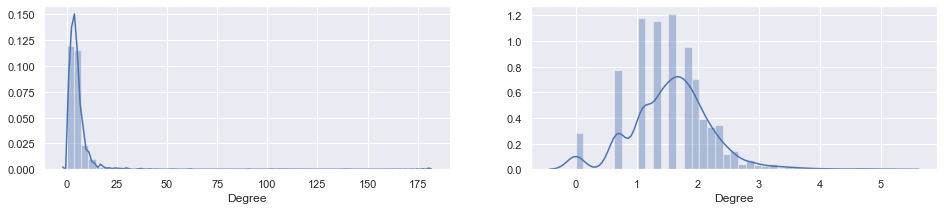

In [227]:
plt.figure(figsize=(16,3))
plt.subplot(121)
sns.distplot(deg_df.Degree)

plt.subplot(122)
sns.distplot(deg_df.Degree.apply(np.log1p))

In [228]:
# fig = px.scatter(deg_df, x=deg_df.Institution, y=deg_df.Degree, color=deg_df.Degree, marginal_y="violin",marginal_x="box")
                                                                         
fig = px.scatter(deg_df, x=deg_df.Institution, y=deg_df.Degree, color=deg_df.Degree, marginal_y="violin")
                                                                         
fig.show()

In [44]:
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 2272
Number of edges: 5881
Average degree:   5.1769


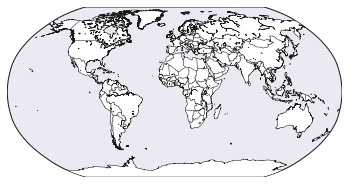

In [249]:
m = Basemap(projection='robin',lon_0=0,resolution='l')

m.drawcountries(linewidth = 0.5)
m.fillcontinents(color='white',lake_color='white')
m.drawcoastlines(linewidth=0.5)

In [231]:
coordinates = (40.864263, -72.875168)
results = rg.search(coordinates)

results

Loading formatted geocoded file...


[OrderedDict([('lat', '40.89399'),
              ('lon', '-72.89594'),
              ('name', 'Ridge'),
              ('admin1', 'New York'),
              ('admin2', 'Suffolk County'),
              ('cc', 'US')])]

In [256]:
G = nx.Graph()

for count, elem in enumerate(df['aff_nm']):
    if df.loc[count, 'gender'] == 'female':
        G.add_node(elem)

In [257]:
m = Basemap(projection='robin',lon_0=0,resolution='l')

mx, my = m(df['longitude'].values, df['latitude'].values)
pos = {}
for count, elem in enumerate (df['aff_nm']):
    
    if df.loc[count, 'gender'] == 'female':
         pos[elem] = (mx[count], my[count])

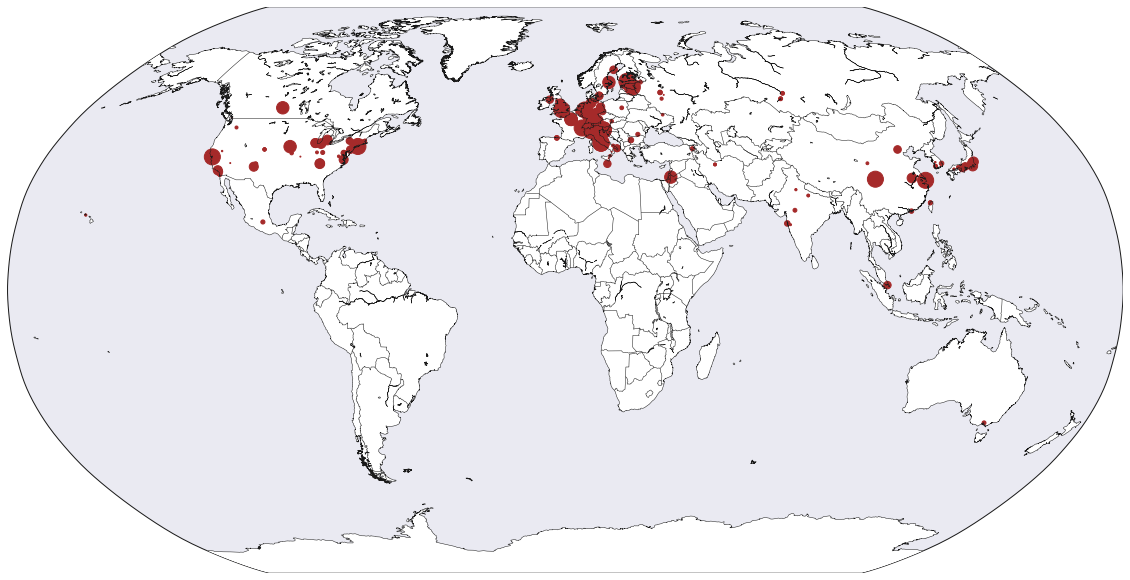

In [258]:
plt.figure(figsize=(20,20))

nx.draw_networkx_nodes(G, pos, node_color = 'brown', 
                       node_size = [df[df['aff_nm'] == s].count() for s in G.nodes()])
nx.draw_networkx_edges(G, pos, edge_color='b', alpha=0.8)

m.drawcountries(linewidth = 0.5)
m.fillcontinents(color='white',lake_color='white')
m.drawcoastlines(linewidth=0.5)
plt.show()

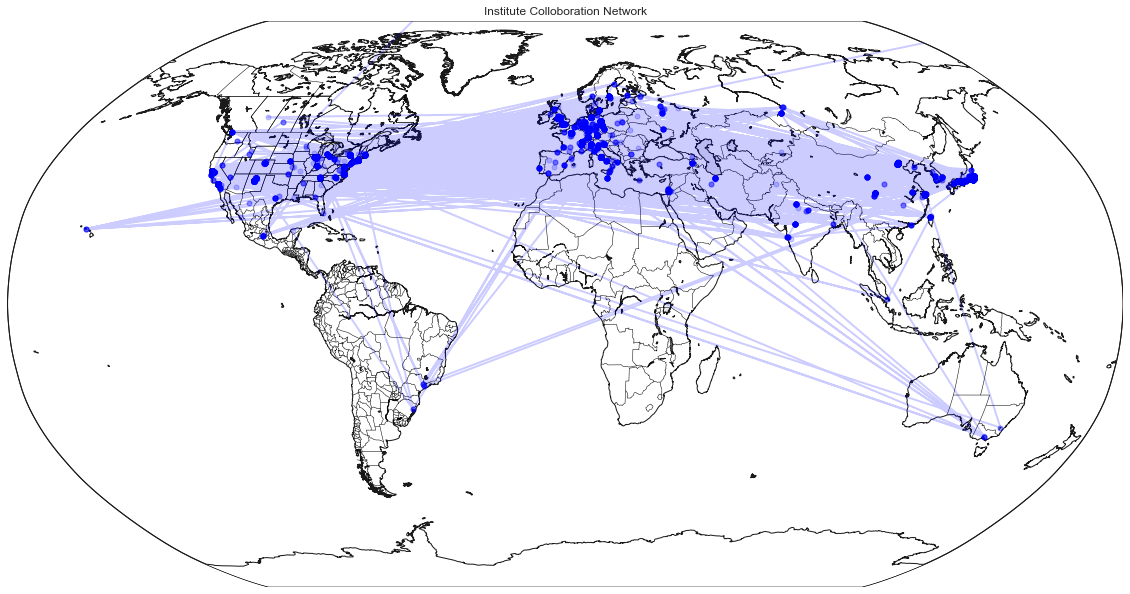

In [379]:
plt.figure(figsize=(20,20))

m = Basemap(projection='robin',lon_0=0,resolution='l')

lat = df.latitude.tolist()
lon = df.longitude.tolist()

x, y = m(lon, lat)
m.plot(x, y, 'o-', markersize=5, linewidth=2, alpha=0.2, color='blue') 

m.drawcoastlines()
m.fillcontinents(color='white')
m.drawmapboundary(fill_color='white')
m.drawstates(color='black')
m.drawcountries(color='black')
plt.title("Institute Colloboration Network")
plt.show() 

## Read and remap Gender based on updated data

In [262]:
df = df.sort_values('year')

In [269]:
fig = px.scatter_geo(df, lat='latitude',lon='longitude', color="gender", hover_name="aff_nm",
               animation_frame="year", projection="natural earth")
fig.show()

In [352]:
fig = px.line_geo(df, lat='latitude',lon='longitude', projection="mercator", animation_frame="year", color='gender')
fig.show()

In [303]:
df.to_csv('Geo_combined_data_v2.csv')

In [382]:
insti_geo = df.groupby(['aff_nm', 'year', 'latitude','longitude','gender'], as_index=False).agg({'female':sum, 'male':sum})
insti_geo

aff_nm  year   latitude  \
0     1094 White Oak Lane, Farmington, New York 1442...  2011  42.982599   
1     511 keV Consulting, 247 Loma Entrada, Santa Fe...  2002  35.701532   
2     AB Division, CERN, CH-1211 Geneva 23, Switzerland  2007  46.233049   
3     AIST: National Institute of Advanced Industria...  2014  36.061463   
4     AMTD, Raja Ramanna Centre for Advanced Technol...  2011  22.667050   
...                                                 ...   ...        ...   
3679  and Physics Division, Argonne National Laborat...  2009  41.718281   
3680  and School of Physical Sciences, The Graduate ...  2010  35.261095   
3681  and School of Physical Sciences, The Graduate ...  2010  35.261095   
3682  and The Cockcroft Institute, Daresbury, Warrin...  2007  53.344515   
3683  and UOM—The University of Malta, Msida MSD 06,...  2006  35.902320   

       longitude  gender  female  male  
0     -77.365340    male       0     1  
1    -105.933063    male       0     1  
2       6.055677    male       0     3  
3     140.133891    male       0     1  
4      75.809076    male       0     4  
...          ...     ...     ...   ...  
3679  -87.978868    male       0     1  
3680  139.608389  female       1     0  
3681  139.608389    male       0     1  
3682   -2.641335    male       0     1  
3683   14.484743    male       0     1  

[3684 rows x 7 columns]

In [410]:
insti_geo['%_female'] = [0]*insti_geo.shape[0]
for idx in range(insti_geo.shape[0]):
    insti_geo.loc[idx, '%_female'] = float(100*insti_geo.loc[idx, 'female']/(insti_geo.loc[idx, 'female']+insti_geo.loc[idx, 'male']))
    
insti_geo.sort_values(by='year',inplace=True,ascending=True)   

In [411]:
fig = px.scatter_geo(insti_geo, lat='latitude',lon='longitude', hover_name="aff_nm",color='%_female',size='%_female',
               animation_frame="year", projection="natural earth")

fig.update_layout(
    title="% Female Authors in Institutes across Years",
    font=dict(
        family="Times New Roman",
        size=12,
        color="black"
    )
)
fig.show()

In [385]:
insti_geo['degree'] = [0]*insti_geo.shape[0]

for idx in range(insti_geo.shape[0]):
    insti_geo.loc[idx, 'degree'] = store[insti_geo.loc[idx, 'aff_nm']]
insti_geo    

aff_nm  year   latitude  \
278   Budker Institute of Nuclear Physics, Novosibir...  1998  54.848798   
2367  Laboratory of Nuclear Studies, Cornell Univers...  1998  42.446705   
2014  Institute of Physics, University of São Paulo,...  1998 -23.561399   
2377  Laboratório Nacional de Luz Síncrotron, Cx.  P...  1998 -22.803973   
410                CERN, CH-1211 Geneve 23, Switzerland  1998  46.233049   
...                                                 ...   ...        ...   
999   Department of Physics, University of Liverpool...  2015  53.403733   
3341  Technische Universität Darmstadt, Schloßgarten...  2015  49.879287   
548   Center for Relativistic Laser Science, Institu...  2015  35.227791   
1452  GSI Helmholtzzentrum für Schwerionenforschung,...  2015  49.931493   
2139  John Adams Institute at Royal Holloway, Univer...  2015  51.425673   

       longitude  gender  female  male  %_female  degree  
278    83.111014  female       1     0     100.0       4  
2367  -76.483058    male       0     5       0.0      18  
2014  -46.730789    male       0     1       0.0       9  
2377  -47.053931    male       0     3       0.0       3  
410     6.055677    male       0     1       0.0       4  
...          ...     ...     ...   ...       ...     ...  
999    -2.963684    male       0     1       0.0       3  
3341    8.654367    male       0     2       0.0       4  
548   126.845164    male       0     3       0.0       8  
1452    8.679360    male       0    10       0.0       7  
2139   -0.563063    male       0     7       0.0      17  

[3684 rows x 9 columns]

In [1]:
fig = px.scatter_geo(insti_geo, lat='latitude',lon='longitude', hover_name="aff_nm",color='degree',size='degree',
               animation_frame="year", projection="orthographic")

fig.show()

NameError: name 'px' is not defined

In [403]:
high = insti_geo[(insti_geo['%_female'] >= 0) & (insti_geo['male'] > 0)]

In [404]:
high

aff_nm  year   latitude  \
2367  Laboratory of Nuclear Studies, Cornell Univers...  1998  42.446705   
2014  Institute of Physics, University of São Paulo,...  1998 -23.561399   
2377  Laboratório Nacional de Luz Síncrotron, Cx.  P...  1998 -22.803973   
410                CERN, CH-1211 Geneve 23, Switzerland  1998  46.233049   
558   Centre de Spectrométrie Nucléaire et de Spectr...  1998  48.697161   
...                                                 ...   ...        ...   
999   Department of Physics, University of Liverpool...  2015  53.403733   
3341  Technische Universität Darmstadt, Schloßgarten...  2015  49.879287   
548   Center for Relativistic Laser Science, Institu...  2015  35.227791   
1452  GSI Helmholtzzentrum für Schwerionenforschung,...  2015  49.931493   
2139  John Adams Institute at Royal Holloway, Univer...  2015  51.425673   

       longitude gender  female  male  %_female  degree  
2367  -76.483058   male       0     5       0.0      18  
2014  -46.730789   male       0     1       0.0       9  
2377  -47.053931   male       0     3       0.0       3  
410     6.055677   male       0     1       0.0       4  
558     2.189617   male       0     2       0.0       6  
...          ...    ...     ...   ...       ...     ...  
999    -2.963684   male       0     1       0.0       3  
3341    8.654367   male       0     2       0.0       4  
548   126.845164   male       0     3       0.0       8  
1452    8.679360   male       0    10       0.0       7  
2139   -0.563063   male       0     7       0.0      17  

[2861 rows x 9 columns]